In [ ]:
!pip install --upgrade gensim

In [ ]:
import pandas as pd
import numpy as np
import gensim
from gensim.models.phrases import Phrases, Phraser
import multiprocessing
import itertools
import scipy.sparse
import seaborn as sbn
import time
from gensim.models import Word2Vec
from collections import defaultdict
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA

In [ ]:
# Load appropriate CSVs from respective directories

df1 = pd.read_csv('stem_train_bodies.csv')
df2 = pd.read_csv('stem_train_stances.csv')

dfinal = df2.merge(df1, on="Body ID", how='left')

model = Word2Vec.load('stem_model.model')
word_vectors = model.wv

In [ ]:
dfinal.head()

,Headline,Body ID,Stance,articleBody
0,"['polic', 'find', 'mass', 'grave', 'least', '1...",712,unrelated,"['danni', 'boyl', 'direct', 'untitl', 'film', ..."
1,"['hundr', 'palestinian', 'flee', 'flood', 'gaz...",158,agree,"['hundr', 'palestinian', 'evacu', 'home', 'sun..."
2,"['christian', 'bale', 'pass', 'role', 'steve',...",137,unrelated,"['30yearold', 'moscow', 'resid', 'hospit', 'wo..."
3,"['hbo', 'appl', 'talk', '15month', 'appl', 'tv...",1034,unrelated,"['reuter', 'canadian', 'soldier', 'shot', 'can..."
4,"['spider', 'burrow', 'tourist', 'stomach', 'ch...",1923,disagree,"['fear', 'arachnophob', 'stori', 'bunburi', 's..."


In [ ]:
df1['articleBody'] = df1['articleBody'].replace("'",'',regex=True)
df1['articleBody'] = df1['articleBody'].replace('\]','',regex=True)
df1['articleBody'] = df1['articleBody'].replace('\[','',regex=True)
df1['articleBody'] = df1['articleBody'].replace(',','',regex=True)

dfinal['Headline'] = dfinal['Headline'].replace("'",'',regex=True)
dfinal['Headline'] = dfinal['Headline'].replace('\]','',regex=True)
dfinal['Headline'] = dfinal['Headline'].replace('\[','',regex=True)
dfinal['Headline'] = dfinal['Headline'].replace(',','',regex=True)

In [ ]:
df1.head()

,Body ID,articleBody
0,0,small meteorit crash wood area nicaragua capit...
1,4,last week hint come ebola fear spread across a...
2,5,newser wonder long quarter pounder chees last ...
3,6,post photo guntot child onlin isi support anno...
4,7,least 25 suspect boko haram insurg kill clash ...


In [ ]:
dfinal.head()

,Headline,Body ID,Stance,articleBody
0,polic find mass grave least 15 bodi near mexic...,712,unrelated,"['danni', 'boyl', 'direct', 'untitl', 'film', ..."
1,hundr palestinian flee flood gaza israel open dam,158,agree,"['hundr', 'palestinian', 'evacu', 'home', 'sun..."
2,christian bale pass role steve job actor repor...,137,unrelated,"['30yearold', 'moscow', 'resid', 'hospit', 'wo..."
3,hbo appl talk 15month appl tv stream servic la...,1034,unrelated,"['reuter', 'canadian', 'soldier', 'shot', 'can..."
4,spider burrow tourist stomach chest,1923,disagree,"['fear', 'arachnophob', 'stori', 'bunburi', 's..."


# Average Word2Vec (AvgW2Vec)

In [ ]:
avg_doc_w2v = {}
max_i = 0
for  id, (i, doc) in zip(df1['Body ID'], enumerate(df1['articleBody'])):
  doc_vector = np.zeros(300)
  sum = 0
  count_words = 0
  for word in (doc).split():
    if i > max_i: max_i = i
    if word in word_vectors.key_to_index.keys():
      vec = word_vectors[word]
      doc_vector += vec
      count_words += 1
  if count_words != 0:
    doc_vector = doc_vector / count_words
  avg_doc_w2v[id] = doc_vector
len(avg_doc_w2v.keys())

1683

In [ ]:
avg_headl_w2v = {}
for id, headline in enumerate(dfinal['Headline']):
  doc_vector = np.zeros(300)
  sum = 0
  count_words = 0
  for word in headline.split():
    if word in word_vectors.key_to_index.keys():
        vec = word_vectors[word]
        sum += vec
        count_words += 1
  if count_words != 0:
    avg_headl_w2v[id] = sum / count_words


In [ ]:
dataset_avg = pd.DataFrame()
dataset_avg['Body ID'] = pd.Series(avg_doc_w2v.keys())
art_avg_dataset = pd.DataFrame(avg_doc_w2v.values())
head_avg_dataset = pd.DataFrame(avg_headl_w2v.values())

head_avg_dataset.rename(columns={i:i+300 for i in range(300)}, inplace=True)
dat_avg = pd.concat([dataset_avg, art_avg_dataset], axis=1)
dfinal_avg = pd.merge(dfinal, dat_avg, on="Body ID", how='left')
dfinal_avg = pd.concat([dfinal_avg, head_avg_dataset], axis=1)
dfinal_avg.drop('Headline', inplace=True, axis=1)
dfinal_avg.drop('Body ID', inplace=True, axis=1)
dfinal_avg.drop('articleBody', inplace=True, axis=1)


In [ ]:
dfinal_avg.head()

,Stance,0,1,2,3,4,5,6,7,8,...,590,591,592,593,594,595,596,597,598,599
0,unrelated,-0.108918,-0.017108,0.193218,0.233860,0.100564,-0.101321,-0.085372,-0.143302,-0.206547,...,0.305774,-0.233355,0.327400,-0.095411,0.390860,0.466803,-0.070472,-0.164089,-0.219697,0.044204
1,agree,-0.112005,-0.062158,0.191225,0.264260,0.189045,0.022649,-0.097055,-0.031333,0.008544,...,-0.393489,-0.151865,0.059253,-0.211322,0.434388,0.094537,-0.079487,0.059241,0.393394,-0.448629
2,unrelated,-0.115369,-0.002260,-0.080152,0.123665,-0.178450,-0.071642,0.014065,0.021280,0.045951,...,-0.056128,-0.040647,0.394780,0.423958,0.041605,0.097411,-0.133292,0.249609,0.132414,0.150441
3,unrelated,-0.148708,-0.200602,0.056886,-0.061171,0.154588,-0.029900,0.115966,0.170023,0.154862,...,-0.088485,-0.719990,0.219513,-0.166457,0.398592,0.248503,-0.417713,-0.058685,-0.426351,0.072392
4,disagree,-0.193598,0.014490,-0.039109,-0.080124,-0.057101,-0.139405,0.028060,-0.089422,0.123513,...,-0.157862,0.090473,0.397993,0.302605,-0.235019,-0.231190,-0.286561,0.033190,0.020423,-0.363568


# # TF-IDF-Average_W2Vec (TFIDF-AvgW2Vec)

In [ ]:
corpus = list(df1['articleBody']) + list(dfinal['Headline'])
voc = list(word_vectors.key_to_index.keys())

In [ ]:
len(voc)

In [ ]:
vectorizer = TfidfVectorizer(vocabulary=voc)

X = vectorizer.fit_transform(corpus)

In [ ]:
def make_tfidf_scores(doc, X, vectorizer):
  feature_index = X[doc,:].nonzero()[1]
  feature_names = vectorizer.get_feature_names_out()
  tfidf_scores = zip(feature_index, [X[doc, x] for x in feature_index])
  tfidf_dict = {}
  for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    tfidf_dict[w] = s
  
  return tfidf_dict

In [ ]:
# docs
tfidf_doc_vectors_rev = {}
max_i = 0
for  id, (i, doc) in zip(df1['Body ID'], enumerate(df1['articleBody'])):
  doc_vector = np.zeros(300)
  weight_sum = 0
  tfidf_dict = make_tfidf_scores(i, X, vectorizer)
  for word in (doc).split():
      if i > max_i: max_i = i
      if word in tfidf_dict.keys() and word in word_vectors.key_to_index.keys():
        vec = word_vectors[word]
        tf_idf = tfidf_dict[word] * (doc.count(word)/ len(doc))
        doc_vector += vec * tf_idf
        weight_sum += tf_idf

      
  if weight_sum != 0:    
    doc_vector = doc_vector / weight_sum
    
  tfidf_doc_vectors_rev[id] = doc_vector

In [ ]:
# headlines

tfidf_headl_vectors_rev = {}
for id, headline in enumerate(dfinal['Headline']):
  doc_vector = np.zeros(300)
  weight_sum = 0
  tfidf_dict = make_tfidf_scores(id+max_i+1, X, vectorizer)
  for word in headline.split():
    if word in tfidf_dict.keys() and word in word_vectors.key_to_index.keys():
        vec = word_vectors[word]
        tf_idf = tfidf_dict[word] * (headline.count(word)/ len(headline))
        doc_vector += vec * tf_idf
        weight_sum += tf_idf
  if weight_sum != 0:
    doc_vector = doc_vector / weight_sum
  tfidf_headl_vectors_rev[id] = doc_vector

In [ ]:
dataset = pd.DataFrame()
dataset['Body ID'] = pd.Series(tfidf_doc_vectors_rev.keys())
art_dataset = pd.DataFrame(tfidf_doc_vectors_rev.values())
head_dataset = pd.DataFrame(tfidf_headl_vectors_rev.values())

head_dataset.rename(columns={i:i+300 for i in range(300)}, inplace=True)
dat = pd.concat([dataset, art_dataset], axis=1)

final_dataset = pd.merge(dfinal, dat, on="Body ID", how='left')
final_dataset = pd.concat([final_dataset, head_dataset], axis=1)
final_dataset.head()

,Headline,Body ID,Stance,articleBody,0,1,2,3,4,5,...,590,591,592,593,594,595,596,597,598,599
0,polic find mass grave least 15 bodi near mexic...,712,unrelated,"['danni', 'boyl', 'direct', 'untitl', 'film', ...",-0.171057,-0.082584,0.215683,0.206734,-0.009819,-0.097900,...,0.126473,-0.205361,0.269870,-0.129937,0.432392,0.590926,-0.125428,-0.310223,-0.146373,0.041622
1,hundr palestinian flee flood gaza israel open dam,158,agree,"['hundr', 'palestinian', 'evacu', 'home', 'sun...",-0.298522,-0.055075,0.342310,0.681222,0.458479,0.125410,...,-0.430141,-0.154002,0.049854,-0.196059,0.410060,0.131988,-0.077302,0.075580,0.418365,-0.464769
2,christian bale pass role steve job actor repor...,137,unrelated,"['30yearold', 'moscow', 'resid', 'hospit', 'wo...",-0.252785,-0.015667,-0.180554,0.182739,-0.292235,-0.070346,...,-0.054925,-0.078223,0.390497,0.451815,0.047742,0.094685,-0.152379,0.261834,0.165340,0.120502
3,hbo appl talk 15month appl tv stream servic la...,1034,unrelated,"['reuter', 'canadian', 'soldier', 'shot', 'can...",-0.056447,-0.149818,0.112567,-0.056328,0.023814,-0.084332,...,-0.065674,-0.702702,0.163023,-0.195219,0.518070,0.244464,-0.390765,-0.178995,-0.463528,0.082407
4,spider burrow tourist stomach chest,1923,disagree,"['fear', 'arachnophob', 'stori', 'bunburi', 's...",-0.509238,0.006763,-0.070009,-0.235011,-0.041121,-0.259600,...,-0.122703,0.073519,0.439258,0.327775,-0.200509,-0.243617,-0.277261,0.024847,0.045978,-0.392236


In [ ]:
final_dataset.drop('Headline', inplace=True, axis=1)
final_dataset.drop('Body ID', inplace=True, axis=1)
final_dataset.drop('articleBody_x', inplace=True, axis=1)
final_dataset.drop('articleBody_y', inplace=True, axis=1)
final_dataset.head()

,Stance,0,1,2,3,4,5,6,7,8,...,590,591,592,593,594,595,596,597,598,599
0,unrelated,-0.171057,-0.082584,0.215683,0.206734,-0.009819,-0.097900,0.055656,-0.018223,-0.178446,...,0.126473,-0.205361,0.269870,-0.129937,0.432392,0.590926,-0.125428,-0.310223,-0.146373,0.041622
1,agree,-0.298522,-0.055075,0.342310,0.681222,0.458479,0.125410,-0.408857,-0.264413,0.002812,...,-0.430141,-0.154002,0.049854,-0.196059,0.410060,0.131988,-0.077302,0.075580,0.418365,-0.464769
2,unrelated,-0.252785,-0.015667,-0.180554,0.182739,-0.292235,-0.070346,0.125618,0.156440,0.054239,...,-0.054925,-0.078223,0.390497,0.451815,0.047742,0.094685,-0.152379,0.261834,0.165340,0.120502
3,unrelated,-0.056447,-0.149818,0.112567,-0.056328,0.023814,-0.084332,0.071311,0.213152,0.170081,...,-0.065674,-0.702702,0.163023,-0.195219,0.518070,0.244464,-0.390765,-0.178995,-0.463528,0.082407
4,disagree,-0.509238,0.006763,-0.070009,-0.235011,-0.041121,-0.259600,0.007316,0.006714,0.369734,...,-0.122703,0.073519,0.439258,0.327775,-0.200509,-0.243617,-0.277261,0.024847,0.045978,-0.392236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49967,unrelated,0.040290,-0.066994,0.189712,-0.067127,0.233854,0.086153,-0.140329,-0.059095,-0.082602,...,-0.191228,0.364483,-0.024476,-0.063360,0.076139,-0.047218,-0.081532,0.067703,0.346184,-0.088055
49968,unrelated,0.217877,-0.197110,-0.166787,-0.192188,0.200899,-0.173280,-0.111901,-0.073371,0.125166,...,-0.151537,-0.094567,0.116050,0.124974,0.084965,0.277163,0.072437,0.112550,0.066987,-0.183630
49969,agree,0.057565,-0.000547,0.058606,0.211191,0.186641,0.086164,0.165342,0.092409,0.240768,...,0.228726,-0.351728,0.347019,-0.267433,0.325422,0.485167,0.110018,-0.041775,-0.113041,0.104897
49970,discuss,-0.290982,-0.386433,0.039869,-0.041009,0.028766,0.023890,0.006107,0.167405,-0.064738,...,0.028935,-0.108160,0.319344,-0.322796,0.036591,0.235133,0.169478,0.125537,-0.030944,-0.024082


In [ ]:
enc = LabelEncoder()

In [ ]:
dfinal_avg['Stance'] = enc.fit_transform(dfinal_avg['Stance'])
dfinal_avg.head()

,Stance,0,1,2,3,4,5,6,7,8,...,590,591,592,593,594,595,596,597,598,599
0,3,-0.108918,-0.017108,0.193218,0.233860,0.100564,-0.101321,-0.085372,-0.143302,-0.206547,...,0.305774,-0.233355,0.327400,-0.095411,0.390860,0.466803,-0.070472,-0.164089,-0.219697,0.044204
1,0,-0.112005,-0.062158,0.191225,0.264260,0.189045,0.022649,-0.097055,-0.031333,0.008544,...,-0.393489,-0.151865,0.059253,-0.211322,0.434388,0.094537,-0.079487,0.059241,0.393394,-0.448629
2,3,-0.115369,-0.002260,-0.080152,0.123665,-0.178450,-0.071642,0.014065,0.021280,0.045951,...,-0.056128,-0.040647,0.394780,0.423958,0.041605,0.097411,-0.133292,0.249609,0.132414,0.150441
3,3,-0.148708,-0.200602,0.056886,-0.061171,0.154588,-0.029900,0.115966,0.170023,0.154862,...,-0.088485,-0.719990,0.219513,-0.166457,0.398592,0.248503,-0.417713,-0.058685,-0.426351,0.072392
4,1,-0.193598,0.014490,-0.039109,-0.080124,-0.057101,-0.139405,0.028060,-0.089422,0.123513,...,-0.157862,0.090473,0.397993,0.302605,-0.235019,-0.231190,-0.286561,0.033190,0.020423,-0.363568


In [ ]:
final_dataset['Stance'] = enc.fit_transform(final_dataset['Stance'])
final_dataset.head()

,Stance,0,1,2,3,4,5,6,7,8,...,590,591,592,593,594,595,596,597,598,599
0,3,-0.171057,-0.082584,0.215683,0.206734,-0.009819,-0.097900,0.055656,-0.018223,-0.178446,...,0.126473,-0.205361,0.269870,-0.129937,0.432392,0.590926,-0.125428,-0.310223,-0.146373,0.041622
1,0,-0.298522,-0.055075,0.342310,0.681222,0.458479,0.125410,-0.408857,-0.264413,0.002812,...,-0.430141,-0.154002,0.049854,-0.196059,0.410060,0.131988,-0.077302,0.075580,0.418365,-0.464769
2,3,-0.252785,-0.015667,-0.180554,0.182739,-0.292235,-0.070346,0.125618,0.156440,0.054239,...,-0.054925,-0.078223,0.390497,0.451815,0.047742,0.094685,-0.152379,0.261834,0.165340,0.120502
3,3,-0.056447,-0.149818,0.112567,-0.056328,0.023814,-0.084332,0.071311,0.213152,0.170081,...,-0.065674,-0.702702,0.163023,-0.195219,0.518070,0.244464,-0.390765,-0.178995,-0.463528,0.082407
4,1,-0.509238,0.006763,-0.070009,-0.235011,-0.041121,-0.259600,0.007316,0.006714,0.369734,...,-0.122703,0.073519,0.439258,0.327775,-0.200509,-0.243617,-0.277261,0.024847,0.045978,-0.392236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49967,3,0.040290,-0.066994,0.189712,-0.067127,0.233854,0.086153,-0.140329,-0.059095,-0.082602,...,-0.191228,0.364483,-0.024476,-0.063360,0.076139,-0.047218,-0.081532,0.067703,0.346184,-0.088055
49968,3,0.217877,-0.197110,-0.166787,-0.192188,0.200899,-0.173280,-0.111901,-0.073371,0.125166,...,-0.151537,-0.094567,0.116050,0.124974,0.084965,0.277163,0.072437,0.112550,0.066987,-0.183630
49969,0,0.057565,-0.000547,0.058606,0.211191,0.186641,0.086164,0.165342,0.092409,0.240768,...,0.228726,-0.351728,0.347019,-0.267433,0.325422,0.485167,0.110018,-0.041775,-0.113041,0.104897
49970,2,-0.290982,-0.386433,0.039869,-0.041009,0.028766,0.023890,0.006107,0.167405,-0.064738,...,0.028935,-0.108160,0.319344,-0.322796,0.036591,0.235133,0.169478,0.125537,-0.030944,-0.024082


# Choose method here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
     final_dataset.loc[:, final_dataset.columns != 'Stance'], final_dataset['Stance'], test_size=0.20, random_state=42)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
     dfinal_avg.loc[:, dfinal_avg.columns != 'Stance'], dfinal_avg['Stance'], test_size=0.20, random_state=42)

In [ ]:
X_train.shape

(39977, 600)

In [ ]:
selector = VarianceThreshold()
std_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
pca = PCA()
ros = RandomOverSampler()

# MLP Classifier

In [ ]:
mlp_clf = MLPClassifier()


steps = [('scaler', min_max_scaler),
         ('ros', ros),
         ('pca', pca),
         ('mlp', mlp_clf)]

pipe = Pipeline(steps=steps, memory='tmp')

n_components = [600]
alpha = [0.0001]
activation = ['relu']
hidden_layer_sizes = [(300, 200, 200)]
# 'pca__n_components':n_components,
params = {'pca__n_components':n_components,
          'mlp__hidden_layer_sizes': hidden_layer_sizes,
          'mlp__activation': activation,
          'mlp__alpha': alpha}

estimator = GridSearchCV(pipe, param_grid=params, cv=10, scoring='f1_macro', n_jobs=-1)
start_time = time.time()

estimator.fit(X_train, y_train)
mlp_preds = estimator.predict(X_test)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:217: UserWarning: Persisting input arguments took 1.16s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name],


In [ ]:
print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test, mlp_preds))
print(estimator.best_estimator_)
print(estimator.best_params_)

Συνολικός χρόνος fit και predict: 5093.587464570999 seconds
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       703
           1       0.86      0.80      0.83       180
           2       0.95      0.98      0.97      1779
           3       1.00      1.00      1.00      7333

    accuracy                           0.98      9995
   macro avg       0.93      0.92      0.92      9995
weighted avg       0.98      0.98      0.98      9995

Pipeline(memory='tmp',
         steps=[('scaler', MinMaxScaler()), ('ros', RandomOverSampler()),
                ('pca', PCA(n_components=600)),
                ('mlp', MLPClassifier(hidden_layer_sizes=(300, 200, 200)))])
{'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (300, 200, 200), 'pca__n_components': 600}


# Confusion Matrix Plot

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
cf_matrix = confusion_matrix(y_test, mlp_preds)
print(cf_matrix)

[[ 628   17   53    5]
 [  22  144   11    3]
 [  27    7 1738    7]
 [   4    0   21 7308]]


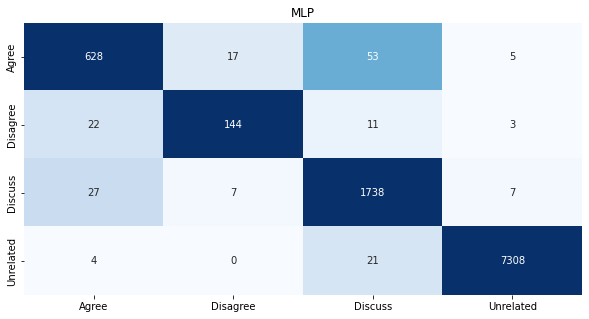

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.title("MLP")
labels = ['Agree', 'Disagree', 'Discuss', 'Unrelated']
sns.heatmap(cf_matrix, annot=True, cmap='Blues',vmin=5,vmax=100,fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
plt.show()